In [ ]:
from google.colab import drive
import pandas as pd
import torch
import re
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
#from torchtext.data.utils import get_tokenizer
#from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

#import datasets
#from datasets import Dataset,DatasetDict,Features,Value,ClassLabel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#drive.mount('/content/drive')
DATA_DIR = "../../data/twitter/"
DATA_DIR_DICT = "../../data/reddit/Reddit_Info/"
RESULTS_DIR = "../../results/"

Mounted at /content/drive


In [2]:
#load in data
twt_train = pd.read_csv(DATA_DIR + 'TWT_Training.csv')
twt_val = pd.read_csv(DATA_DIR + 'TWT_Validation.csv')
twt_test = pd.read_csv(DATA_DIR + 'TWT_Test.csv')

In [3]:
# Parameters
SEED = 0
BATCH_SIZE = 48
WORD_EMBED_DIM = 256
HID_EMBED_DIM = 256
DROPOUT = 0.5
CLIP = 0.25
BPTT = 50
EPOCHS = 30
torch.manual_seed(SEED)


In [4]:
# Preprocess Data

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S*|\S*\.com\S*|\S*www\S*", " ", text) # eliminate urls
    text = re.sub(r"\s@\S+", " ", text) # eliminate @mentions
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.strip()
    text = text.split()
    return [w for w in text if len(w) > 2]

# Build vocabulary from training data

def build_vocab(dataset):
    word_list = [word for text in dataset['text'] for word in preprocess_text(text)]
    word_counts = Counter(word_list)
    vocab = {word: i + 1 for i, (word, _) in enumerate(word_counts.most_common())}
    vocab["<unk>"] = 0  # Unknown words
    return vocab

def twt_text_to_sequence(text):
    return [twt_train_vocab[word] for word in preprocess_text(text) if word in twt_train_vocab]

def red_text_to_sequence(text):
    return [red_train_vocab[word] for word in preprocess_text(text) if word in red_train_vocab]

In [5]:
twt_vocab = build_vocab(twt_train)
twt_val_vocab = build_vocab(twt_val)

In [6]:
twt_train.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [7]:
 #Twitter preprocessing

twt_train_list = [word for sentence in twt_train['text'] for word in preprocess_text(sentence)]
twt_train_count = Counter(twt_train_list)
twt_train_vocab = {word: i + 1 for i, (word, _) in enumerate(twt_train_count.most_common())}
twt_train_vocab_size = len(twt_train_vocab) + 1

twt_train['sequence'] = twt_train['text'].apply(twt_text_to_sequence)

twt_max_len = max(len(seq) for seq in twt_train['sequence'])
twt_train['padded_sequence'] = twt_train['sequence'].apply(lambda seq: seq + [0] * (twt_max_len - len(seq)))
twt_X = np.array(twt_train['padded_sequence'].tolist())
twt_y = np.array(twt_train['label'])


twt_val_list = [word for sentence in twt_val['text'] for word in preprocess_text(sentence)]
twt_val_count = Counter(twt_val_list)
twt_val_vocab = {word: i + 1 for i, (word, _) in enumerate(twt_val_count.most_common())}
twt_val_vocab_size = len(twt_val_vocab) + 1

twt_val['sequence'] = twt_val['text'].apply(twt_text_to_sequence)

twt_val_max_len = max(len(seq) for seq in twt_val['sequence'])
twt_val['padded_sequence'] = twt_val['sequence'].apply(lambda seq: seq + [0] * (twt_val_max_len - len(seq)))
twt_val_X = np.array(twt_val['padded_sequence'].tolist())
twt_val_y = np.array(twt_val['label'])

twt_test_list = [word for sentence in twt_test['text'] for word in preprocess_text(sentence)]
twt_test_count = Counter(twt_test_list)
twt_test_vocab = {word: i + 1 for i, (word, _) in enumerate(twt_test_count.most_common())}
twt_test_vocab_size = len(twt_test_vocab) + 1

twt_test['sequence'] = twt_test['text'].apply(twt_text_to_sequence)

twt_test_max_len = max(len(seq) for seq in twt_test['sequence'])
twt_test['padded_sequence'] = twt_test['sequence'].apply(lambda seq: seq + [0] * (twt_test_max_len - len(seq)))
twt_test_X = np.array(twt_test['padded_sequence'].tolist())
twt_test_y = np.array(twt_test['label'])

<ipython-input-8-16db5af2aeb2>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=twt_train["label"], palette="Blues") # Assign the plot to an axes object
<ipython-input-8-16db5af2aeb2>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(twt_label_list, rotation=45, ha="right")  # Set x-tick labels with rotation and alignment


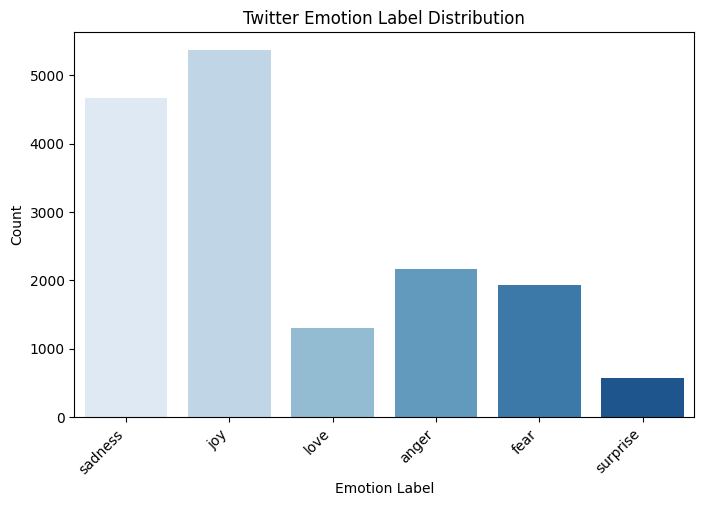

In [8]:
## VISUALIZE DATASETS HERE

#plot label distributions

# label names

twt_label_names = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
twt_label_list = list(twt_label_names.values())


def process_labels(label):
    if isinstance(label, str):
        return [int(x) for x in label.split(",")]
    else:
        return [int(label)]

# Twitter Dataset Label Distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=twt_train["label"], palette="Blues") # Assign the plot to an axes object
plt.title("Twitter Emotion Label Distribution")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
ax.set_xticklabels(twt_label_list, rotation=45, ha="right")  # Set x-tick labels with rotation and alignment
plt.show()

In [9]:
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

twt_train_dataset = EmotionDataset(twt_X, twt_y)
twt_train_loader = DataLoader(twt_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

twt_val_dataset = EmotionDataset(twt_val_X,twt_val_y)
twt_val_loader = DataLoader(twt_val_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

In [10]:
# Vanilla RNN

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, nlayers, output_size, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.nlayers = nlayers
        self.nhid = hidden_size
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        output = self.dropout(output)
        decoded = self.fc(output[:, -1, :])
        #decoded = decoded.view(-1, decoded.size(2))
        return decoded, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.nlayers, batch_size, self.nhid).zero_()

In [11]:
# LSTM Model

class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, nlayers, output_size, dropout=DROPOUT, tie_weights=False):
        super(LSTMModel, self).__init__()
        self.embedding_size = embedding_size
        self.encoder = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, nlayers, dropout=dropout, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.nhid = hidden_size
        self.nlayers = nlayers
        self.tie_weights = tie_weights

  def init_weights(self):
      initrange = 0.1
      if self.tie_weights:
          assert self.nhid == self.embedding_size, 'incorrect dimensions'
          self.decoder.weight = self.encoder.weight

      self.init_weights()

      # uniform encoding
      self.encoder.weight.data.uniform_(-initrange, initrange)

      # uniform decoding
      self.decoder.weight.data.uniform_(-initrange, initrange)
      self.decoder.bias.data.zero_()

  def forward(self, input, hidden):
      embedded = self.dropout(self.encoder(input))
      output, hidden = self.lstm(embedded, hidden)
      output = self.dropout(output)
      decoded = self.decoder(output[:, -1, :])
      #decoded = decoded.view(-1, decoded.size(2))
      return decoded, hidden


  def init_hidden(self, bsz):
      weight = next(self.parameters())
      return (weight.new_zeros(self.nlayers, bsz, self.nhid),
          weight.new_zeros(self.nlayers, bsz, self.nhid))



In [12]:
# Bidirectional LSTM

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, nlayers, output_size, dropout=DROPOUT, tie_weights=False):
        super(BiLSTMModel, self).__init__()
        self.embedding_size = embedding_size
        self.nhid = hidden_size
        self.dropout = dropout
        self.encoder = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, nlayers, dropout=dropout, batch_first=True, bidirectional=True)
        self.decoder = nn.Linear(hidden_size*2, vocab_size)
        self.nlayers = nlayers
        self.tie_weights = tie_weights
        self.dropout = nn.Dropout(dropout)


    def init_weights(self):
        initrange = 0.1

        if self.tie_weights:
            assert (self.nhid * 2) == self.embedding_size, 'incorrect dimensions'
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        # uniform encoding
        self.encoder.weight.data.uniform_(-initrange, initrange)

        # uniform decoding
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()

    def forward(self, input, hidden):
        embedded = self.dropout(self.encoder(input))
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)
        decoded = self.decoder(output[:, -1, :])
        #decoded = decoded.view(-1, decoded.size(2))
        return decoded, hidden

    def init_hidden(self, batch_size):

        weight = next(self.parameters()).data
        return (weight.new(self.nlayers * 2, batch_size, self.nhid).zero_(),
                weight.new(self.nlayers * 2, batch_size, self.nhid).zero_())

In [13]:
# Attention-based RNN

class AttentionRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, nlayers, dropout=0.6):
        super(AttentionRNN, self).__init__()
        super(AttentionRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, nlayers, dropout=dropout, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)
        self.nhid = hidden_size
        self.nlayers = nlayers

        nn.init.xavier_uniform_(self.attention.weight)
        nn.init.xavier_uniform_(self.fc.weight)


    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.lstm(embedded, hidden)

        attention_scores = self.attention(output).squeeze(2)
        attention_weights = F.softmax(attention_scores, dim=1)

        context_vector = torch.sum(output * attention_weights.unsqueeze(2), dim=1)
        output = self.fc(context_vector)
        #decoded = decoded.view(-1, decoded.size(2))
        return output, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.nlayers * 2, batch_size, self.nhid).zero_(),
                weight.new(self.nlayers * 2, batch_size, self.nhid).zero_())

In [ ]:
# Pre-trained BERT model

n_labels = 6

bert_model_name = "bhadresh-savani/bert-base-uncased-emotion"
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=n_labels)
bert_model.to(device)
bert_model.eval()

twt_train_bert = twt_train.copy()
twt_val_bert = twt_val.copy()
twt_test_bert = twt_test.copy()

twt_train_bert= bert_tokenizer(
    twt_train["text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

twt_val_bert = bert_tokenizer(
    twt_val["text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

twt_test_bert = bert_tokenizer(
    twt_test["text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [15]:
class BertEmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Convert label column to list
train_labels = twt_train["label"].astype("category").cat.codes.tolist()
val_labels = twt_val["label"].astype("category").cat.codes.tolist()
test_labels = twt_test["label"].astype("category").cat.codes.tolist()

# Create datasets
twt_bert_train_dataset = BertEmotionDataset(twt_train_bert, train_labels)
twt_bert_val_dataset = BertEmotionDataset(twt_val_bert, val_labels)
twt_bert_test_dataset = BertEmotionDataset(twt_test_bert, test_labels)

twt_bert_train_loader = DataLoader(twt_bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
twt_bert_val_loader = DataLoader(twt_bert_val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)
twt_bert_test_loader = DataLoader(twt_bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)


In [16]:
# --- Training function ---

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=5, bptt=50):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for batch in train_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            hidden = model.init_hidden(inputs.size(0))
            loss = 0

            # implement bptt
            for t in range(0, inputs.size(1), bptt):
                chunk = inputs[:, t:t + bptt]
                outputs, hidden = model(chunk, hidden)
                loss += criterion(outputs, labels)

            loss.backward()  # backpropagation
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = total_correct / len(train_loader.dataset)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return model


In [17]:
# --- Evaluation function ---

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            abels = labels.long()

            # handle models with hidden states (RNNs, LSTMs)
            if hasattr(model, "init_hidden"):
                hidden = model.init_hidden(inputs.size(0))
                if isinstance(hidden, tuple):
                    hidden = (hidden[0].detach(), hidden[1].detach())
                else:
                    hidden = hidden.detach()
                outputs, _ = model(inputs, hidden)
            else:
                outputs = model(inputs)  # attention rnn

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / len(dataloader.dataset)

    return avg_loss, accuracy


In [18]:
criterion = nn.CrossEntropyLoss() # use crossentropy loss

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Train Vanilla RNN on Twitter Dataset
twt_vanilla_model = RNNModel(twt_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 1, 6, DROPOUT)
twt_vanilla_model = train_model(twt_vanilla_model, twt_train_loader, twt_val_loader,torch.optim.Adam(twt_vanilla_model.parameters()), criterion, device, epochs=EPOCHS, bptt=BPTT )

torch.save(twt_vanilla_model.state_dict(), RESULTS_DIR + "twt_vanilla_model.pth")

Epoch 1/30 | Train Loss: 1.6460 | Train Acc: 0.3123 | Val Loss: 1.5855 | Val Acc: 0.3460
Epoch 2/30 | Train Loss: 1.6079 | Train Acc: 0.3185 | Val Loss: 1.5976 | Val Acc: 0.3460
Epoch 3/30 | Train Loss: 1.6052 | Train Acc: 0.3182 | Val Loss: 1.5856 | Val Acc: 0.2705
Epoch 4/30 | Train Loss: 1.6003 | Train Acc: 0.3186 | Val Loss: 1.5969 | Val Acc: 0.3460
Epoch 5/30 | Train Loss: 1.6031 | Train Acc: 0.3187 | Val Loss: 1.5913 | Val Acc: 0.3460
Epoch 6/30 | Train Loss: 1.5997 | Train Acc: 0.3191 | Val Loss: 1.5865 | Val Acc: 0.3465
Epoch 7/30 | Train Loss: 1.5989 | Train Acc: 0.3229 | Val Loss: 1.5906 | Val Acc: 0.3475
Epoch 8/30 | Train Loss: 1.6020 | Train Acc: 0.3191 | Val Loss: 1.5926 | Val Acc: 0.3465
Epoch 9/30 | Train Loss: 1.6051 | Train Acc: 0.3194 | Val Loss: 1.6415 | Val Acc: 0.2705
Epoch 10/30 | Train Loss: 1.6013 | Train Acc: 0.3192 | Val Loss: 1.5856 | Val Acc: 0.3465
Epoch 11/30 | Train Loss: 1.5999 | Train Acc: 0.3237 | Val Loss: 1.5843 | Val Acc: 0.3465
Epoch 12/30 | Train

In [ ]:
# Train unidirectional LSTM on Twitter dataset
twt_lstm_model = LSTMModel(twt_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 2, 6, dropout=DROPOUT)
twt_lstm_model = train_model(twt_lstm_model, twt_train_loader, twt_val_loader, torch.optim.Adam(twt_lstm_model.parameters()), criterion, device, epochs=EPOCHS, bptt=BPTT)

torch.save(twt_lstm_model.state_dict(), RESULTS_DIR + "twt_lstm_model.pth")

Epoch 1/30 | Train Loss: 1.5885 | Train Acc: 0.3218 | Val Loss: 1.5822 | Val Acc: 0.3465
Epoch 2/30 | Train Loss: 1.5820 | Train Acc: 0.3287 | Val Loss: 1.5876 | Val Acc: 0.3465
Epoch 3/30 | Train Loss: 1.5801 | Train Acc: 0.3317 | Val Loss: 1.5746 | Val Acc: 0.3465
Epoch 4/30 | Train Loss: 1.5203 | Train Acc: 0.3498 | Val Loss: 1.4008 | Val Acc: 0.3845
Epoch 5/30 | Train Loss: 1.3588 | Train Acc: 0.3950 | Val Loss: 1.2190 | Val Acc: 0.4415
Epoch 6/30 | Train Loss: 1.1705 | Train Acc: 0.5172 | Val Loss: 0.9722 | Val Acc: 0.6135
Epoch 7/30 | Train Loss: 0.9284 | Train Acc: 0.6391 | Val Loss: 0.7641 | Val Acc: 0.6920
Epoch 8/30 | Train Loss: 0.7608 | Train Acc: 0.7059 | Val Loss: 0.6296 | Val Acc: 0.7475
Epoch 9/30 | Train Loss: 0.6124 | Train Acc: 0.7881 | Val Loss: 0.4484 | Val Acc: 0.8425
Epoch 10/30 | Train Loss: 0.4878 | Train Acc: 0.8364 | Val Loss: 0.3636 | Val Acc: 0.8520
Epoch 11/30 | Train Loss: 0.3946 | Train Acc: 0.8668 | Val Loss: 0.2642 | Val Acc: 0.9005
Epoch 12/30 | Train

In [ ]:
# Train biidirectional LSTM on Twitter dataset
twt_bilstm_model = BiLSTMModel(twt_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 2, 6, dropout=DROPOUT)
twt_bilstm_model = train_model(twt_bilstm_model, twt_train_loader, twt_val_loader, torch.optim.Adam(twt_bilstm_model.parameters()), criterion, device, epochs=EPOCHS, bptt=BPTT)

torch.save(twt_bilstm_model.state_dict(), RESULTS_DIR + "twt_bilstm_model.pth")

Epoch 1/30 | Train Loss: 1.8115 | Train Acc: 0.3157 | Val Loss: 1.5870 | Val Acc: 0.3465
Epoch 2/30 | Train Loss: 1.6169 | Train Acc: 0.3162 | Val Loss: 1.5909 | Val Acc: 0.3465
Epoch 3/30 | Train Loss: 1.6089 | Train Acc: 0.3137 | Val Loss: 1.5995 | Val Acc: 0.3465
Epoch 4/30 | Train Loss: 1.6061 | Train Acc: 0.3161 | Val Loss: 1.5893 | Val Acc: 0.3465
Epoch 5/30 | Train Loss: 1.6012 | Train Acc: 0.3241 | Val Loss: 1.5832 | Val Acc: 0.3465
Epoch 6/30 | Train Loss: 1.5976 | Train Acc: 0.3220 | Val Loss: 1.5857 | Val Acc: 0.3465
Epoch 7/30 | Train Loss: 1.5950 | Train Acc: 0.3256 | Val Loss: 1.5961 | Val Acc: 0.3465
Epoch 8/30 | Train Loss: 1.5955 | Train Acc: 0.3184 | Val Loss: 1.6005 | Val Acc: 0.3465
Epoch 9/30 | Train Loss: 1.5942 | Train Acc: 0.3209 | Val Loss: 1.5964 | Val Acc: 0.2710
Epoch 10/30 | Train Loss: 1.5941 | Train Acc: 0.3213 | Val Loss: 1.5885 | Val Acc: 0.2705
Epoch 11/30 | Train Loss: 1.5889 | Train Acc: 0.3279 | Val Loss: 1.5837 | Val Acc: 0.3465
Epoch 12/30 | Train

In [ ]:
# Train attentional RNN on Twitter dataset

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

twt_attention_model = AttentionRNN(twt_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 6, 1)
twt_attention_model = train_model(twt_attention_model, twt_train_loader, twt_val_loader, torch.optim.Adam(twt_attention_model.parameters()), criterion, device, epochs=EPOCHS, bptt=BPTT)

torch.save(twt_attention_model.state_dict(), RESULTS_DIR + "twt_attention_model.pth")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


Epoch 1/30 | Train Loss: 1.2699 | Train Acc: 0.4979 | Val Loss: 0.5864 | Val Acc: 0.7720
Epoch 2/30 | Train Loss: 0.6389 | Train Acc: 0.7739 | Val Loss: 0.2957 | Val Acc: 0.8720
Epoch 3/30 | Train Loss: 0.4011 | Train Acc: 0.8574 | Val Loss: 0.2452 | Val Acc: 0.8975
Epoch 4/30 | Train Loss: 0.3063 | Train Acc: 0.8898 | Val Loss: 0.1968 | Val Acc: 0.9015
Epoch 5/30 | Train Loss: 0.2545 | Train Acc: 0.9026 | Val Loss: 0.2032 | Val Acc: 0.9025
Epoch 6/30 | Train Loss: 0.2216 | Train Acc: 0.9160 | Val Loss: 0.2006 | Val Acc: 0.9095
Epoch 7/30 | Train Loss: 0.1924 | Train Acc: 0.9267 | Val Loss: 0.1925 | Val Acc: 0.9155
Epoch 8/30 | Train Loss: 0.1778 | Train Acc: 0.9308 | Val Loss: 0.2037 | Val Acc: 0.9100
Epoch 9/30 | Train Loss: 0.1580 | Train Acc: 0.9396 | Val Loss: 0.2193 | Val Acc: 0.9160
Epoch 10/30 | Train Loss: 0.1478 | Train Acc: 0.9418 | Val Loss: 0.1970 | Val Acc: 0.9195
Epoch 11/30 | Train Loss: 0.1446 | Train Acc: 0.9430 | Val Loss: 0.1884 | Val Acc: 0.9180
Epoch 12/30 | Train

In [ ]:
def compute_metrics(pred):
    logits, labels = pred
    predictions = logits.argmax(axis=-1)  # Get predicted class

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")  # Weighted F1-score

    return {
        "accuracy": accuracy,
        "f1": f1
    }

In [25]:
#Train Bert Model on Twitter data

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="results_twitter_6",
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=500,
    report_to="none",
    fp16=True
)

# Define Trainer
twt_bert_trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=twt_bert_train_dataset,
    eval_dataset=twt_bert_val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
twt_bert_trainer.train()
torch.save(twt_bert_trainer, "/content/results_twitter_6/twt_bert.pth")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.164093,0.932000,0.932428
2,0.110600,0.179915,0.937000,0.936902
3,0.056900,0.211598,0.940500,0.940321


In [ ]:
twt_bert_trainer.save_model(RESULTS_DIR + "twt_bert_model")

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained(RESULTS_DIR + "twt_bert_model")
bert_model.to(device)
bert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Load in Models
# RUN ONLY IF MODELS ARENT ALREADY LOADED

MODEL_PATHS = {
    "Vanilla RNN": RESULTS_DIR + "twt_vanilla_model.pth",
    "LSTM": RESULTS_DIR + "twt_lstm_model.pth",
    "BiLSTM": RESULTS_DIR + "twt_bilstm_model.pth",
    "Attention RNN": RESULTS_DIR + "twt_attention_model.pth",
}

trained_models = {}

# Load models
twt_vanilla_model = RNNModel(twt_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 1, 6, DROPOUT)
twt_vanilla_model.load_state_dict(torch.load(MODEL_PATHS["Vanilla RNN"]))
twt_vanilla_model.to(device)
trained_models["vanilla rnn"] = twt_vanilla_model.eval()

twt_lstm_model = LSTMModel(twt_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 2, 6, dropout=DROPOUT)
twt_lstm_model.load_state_dict(torch.load(MODEL_PATHS["LSTM"]))
twt_lstm_model.to(device)
trained_models["lstm"] = twt_lstm_model.eval()

twt_bilstm_model = BiLSTMModel(twt_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 2, 6, dropout=DROPOUT)
twt_bilstm_model.load_state_dict(torch.load(MODEL_PATHS["BiLSTM"]))
twt_bilstm_model.to(device)
trained_models["bilstm"] = twt_bilstm_model.eval()

twt_attention_model = AttentionRNN(twt_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 6, 1)
twt_attention_model.load_state_dict(torch.load(MODEL_PATHS["Attention RNN"]))
twt_attention_model.to(device)
trained_models["attention"] = twt_attention_model.eval()

In [28]:
# IF MODELS ARE ALREADY LOADED

test_results = {}
trained_models = {
    "Vanilla RNN": twt_vanilla_model,
    "LSTM": twt_lstm_model,
    "BiLSTM": twt_bilstm_model,
    "Attention RNN": twt_attention_model
}

twt_test_dataset = EmotionDataset(twt_test_X, twt_test_y)
twt_test_loader = DataLoader(twt_test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)

In [29]:
#get metrics from test sets

def detach_hidden(hidden):
    """Handles different hidden state formats (RNN vs LSTM)."""
    if isinstance(hidden, tuple):
        return (hidden[0].detach(), hidden[1].detach())
    return hidden.detach()


for name, model in trained_models.items():
    all_preds, all_labels = [], []

    total_loss = 0
    num_batches = 0

    model.eval()
    with torch.no_grad():
        for batch in twt_test_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)

            batch_size = inputs.size(0)
            hidden = model.init_hidden(batch_size)

            hidden = detach_hidden(hidden)

            outputs, hidden = model(inputs, hidden)

            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()
            num_batches += 1

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_preds)
    avg_loss = total_loss / num_batches

    test_results[name] = {"Accuracy (%)": accuracy, "F1-Score": f1, "Cross-Entropy Loss": avg_loss}
    print(f"{name}: Accuracy = {accuracy:.2f}%, F1-Score = {f1:.4f}")

df_test_results = pd.DataFrame(test_results).T

Vanilla RNN: Accuracy = 34.96%, F1-Score = 0.1812
LSTM: Accuracy = 92.43%, F1-Score = 0.9249
BiLSTM: Accuracy = 91.82%, F1-Score = 0.9184
Attention RNN: Accuracy = 92.38%, F1-Score = 0.9235


In [30]:
#metrics from BERT

b_all_labels = []
b_all_preds = []
b_total_loss = 0

with torch.no_grad():
  for batch in twt_bert_test_loader:
      inputs, labels = batch['input_ids'], batch['labels']
      inputs, labels = inputs.to(device), labels.to(device)

      # Get model predictions
      b_outputs = bert_model(input_ids=inputs, attention_mask=(inputs > 0).long()) # pass in dictionary and make attention mask
      b_preds = torch.argmax(b_outputs.logits, dim=1)

      # Collect results
      b_all_labels.extend(labels.cpu().numpy())
      b_all_preds.extend(b_preds.cpu().numpy())

      b_loss = criterion(b_outputs.logits, labels) # corrected to use logits
      b_total_loss += b_loss.item()



# Compute metrics
bert_accuracy = accuracy_score(b_all_labels, b_all_preds)
bert_f1 = f1_score(b_all_labels, b_all_preds, average='weighted')  # Change to 'macro' or 'micro' if needed
avg_b_loss = b_total_loss / len(twt_bert_test_loader)

print(bert_accuracy)
print(bert_f1)
print(avg_b_loss)

test_results["BERT"] = {"Accuracy (%)": bert_accuracy * 100, "F1-Score": bert_f1, "Cross-Entropy Loss": avg_b_loss}
df_test_results = pd.DataFrame(test_results).T

0.9263211382113821
0.9256582748486771
0.24236595076395245


In [31]:
df_test_results

,Accuracy (%),F1-Score,Cross-Entropy Loss
Vanilla RNN,34.959350,0.181183,1.600880
LSTM,92.428862,0.924945,0.181545
BiLSTM,91.819106,0.918383,0.221365
Attention RNN,92.378049,0.923528,0.274201
BERT,92.632114,0.925658,0.242366


In [32]:
# perform McNemar's Test

def compute_mcnemar_test(model1_name, model2_name):
    model1 = trained_models[model1_name]
    model2 = trained_models[model2_name]

    model1_preds, model2_preds, true_labels = [], [], []

    # Special handling for BERT
    if model1_name == "BERT":
        with torch.no_grad():
            for batch in twt_bert_test_loader:
                inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                outputs1 = model1(input_ids=inputs, attention_mask=(inputs > 0).long())
                preds1 = outputs1.logits.argmax(dim=1).cpu().numpy()
                model1_preds.extend(preds1)
                true_labels.extend(labels.cpu().numpy())

    else:  # other model logic
        with torch.no_grad():
            for batch in twt_test_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)

                batch_size = inputs.size(0)
                hidden1 = model1.init_hidden(batch_size)
                hidden1 = detach_hidden(hidden1)

                outputs1, _ = model1(inputs, hidden1)
                preds1 = outputs1.argmax(dim=1).cpu().numpy()  # (batch_size,)

                model1_preds.extend(preds1)
                true_labels.extend(labels.cpu().numpy())

    if model2_name == "BERT":
        with torch.no_grad():
            for batch in twt_bert_test_loader:
                inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                outputs2 = model2(input_ids=inputs, attention_mask=(inputs > 0).long())
                preds2 = outputs2.logits.argmax(dim=1).cpu().numpy()
                model2_preds.extend(preds2)

    else:  # other model logic
        with torch.no_grad():
            for batch in twt_test_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)

                batch_size = inputs.size(0)
                hidden2 = model2.init_hidden(batch_size)
                hidden2 = detach_hidden(hidden2)

                outputs2, _ = model2(inputs, hidden2)
                preds2 = outputs2.argmax(dim=1).cpu().numpy()  # (batch_size,)

                model2_preds.extend(preds2)

    model1_preds = np.array(model1_preds)
    model2_preds = np.array(model2_preds)
    true_labels = np.array(true_labels)


    b = np.sum((model1_preds == true_labels) & (model2_preds != true_labels))
    c = np.sum((model1_preds != true_labels) & (model2_preds == true_labels))
    table = np.array([[0, b], [c, 0]])

    result = mcnemar(table, exact=False, correction=True)
    return result.pvalue

In [33]:
trained_models["BERT"] = bert_model

model_names = list(trained_models.keys())
df_mcnemar = pd.DataFrame(np.nan, index=model_names, columns=model_names)

for i, model1_name in enumerate(model_names):
    for j, model2_name in enumerate(model_names):
        if i < j:
            p_value = compute_mcnemar_test(model1_name, model2_name)
            df_mcnemar.loc[model1_name, model2_name] = p_value
            df_mcnemar.loc[model2_name, model1_name] = p_value


In [34]:
df_mcnemar

,Vanilla RNN,LSTM,BiLSTM,Attention RNN,BERT
Vanilla RNN,NaN,2.667465e-231,6.625607e-218,5.425610e-233,2.623640e-233
LSTM,2.667465e-231,NaN,3.490764e-01,1.000000e+00,7.955114e-01
BiLSTM,6.625607e-218,3.490764e-01,NaN,4.470837e-01,2.144548e-01
Attention RNN,5.425610e-233,1.000000e+00,4.470837e-01,NaN,7.161296e-01
BERT,2.623640e-233,7.955114e-01,2.144548e-01,7.161296e-01,NaN


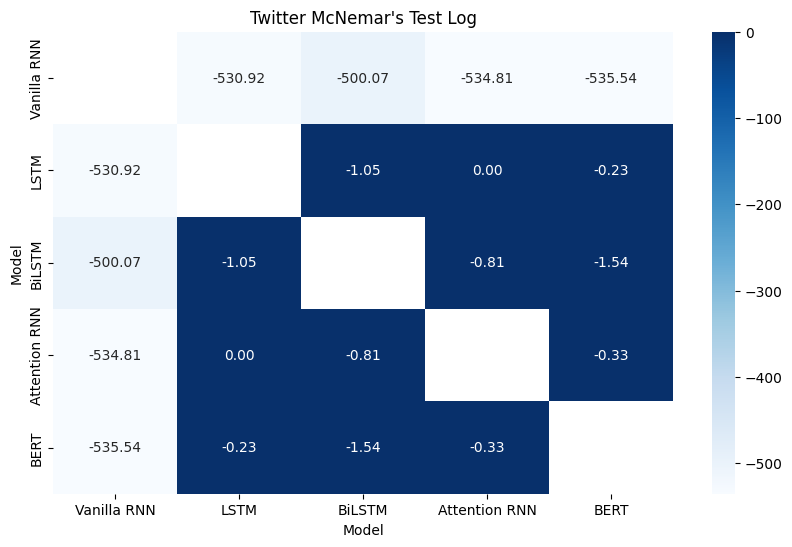

In [35]:
#McNemar's Visualization

plt.figure(figsize=(10, 6))
log_df_mcnemar = np.log(df_mcnemar)
sns.heatmap(log_df_mcnemar, annot=True, cmap="Blues", fmt = '.2f')
plt.title("Twitter McNemar's Test Log")
plt.xlabel("Model")
plt.ylabel("Model")
plt.show()

In [36]:
# plot correct classifications per model

class_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# dictionary to store per-emotion accuracy
per_emotion_accuracy = {}

for name, model in trained_models.items():
    all_preds, all_labels = [], []

    with torch.no_grad():
        if name == "BERT":  # Special handling for BERT
            for batch in twt_bert_test_loader:
                inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                outputs = model(input_ids=inputs, attention_mask=(inputs > 0).long())
                preds = outputs.logits.argmax(dim=1).cpu().numpy()
                labels = labels.cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)
        else:  # Handling for other models
            for batch in twt_test_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)

                batch_size = inputs.size(0)
                hidden = model.init_hidden(batch_size)

                hidden = detach_hidden(hidden)

                preds = torch.argmax(model(inputs, hidden)[0], dim=1).cpu().numpy()
                labels = labels.cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    emotion_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1) * 100
    per_emotion_accuracy[name] = dict(zip(class_names, emotion_accuracy))

df_per_emotion_accuracy = pd.DataFrame(per_emotion_accuracy).T

In [37]:
df_per_emotion_accuracy

,sadness,joy,love,anger,fear,surprise
Vanilla RNN,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000
LSTM,97.727273,94.186047,83.870968,91.729323,82.805430,83.333333
BiLSTM,97.902098,89.825581,95.483871,89.097744,91.855204,62.121212
Attention RNN,96.503497,94.912791,79.354839,92.105263,88.235294,75.757576
BERT,96.853147,94.622093,79.354839,93.233083,92.307692,65.151515


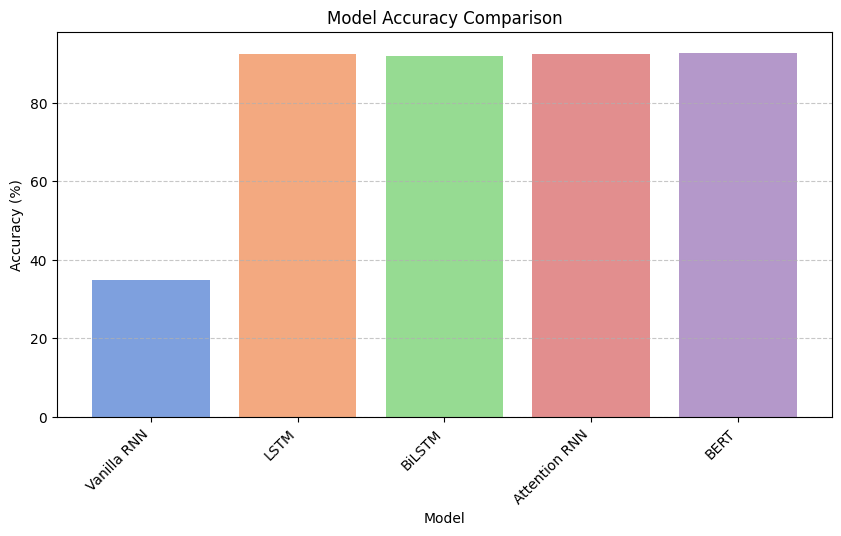

In [38]:
# accuracy bar chart

models = df_test_results.index

# Extract metric values
accuracy_values = df_test_results["Accuracy (%)"].values
f1_values = df_test_results["F1-Score"].values * 100

x = np.arange(len(models))

palette = sns.color_palette("muted", len(models))

plt.figure(figsize=(10, 5))
plt.bar(models, df_test_results["Accuracy (%)"].values,alpha=0.7, color = palette)

plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 98)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()

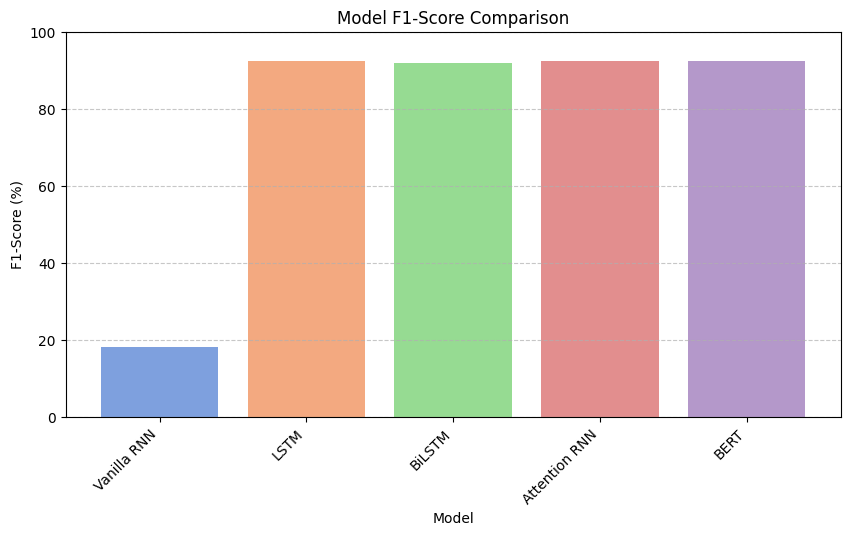

In [39]:
# f1-score bar chart

plt.figure(figsize=(10, 5))
plt.bar(models, df_test_results["F1-Score"].values * 100, color=palette, alpha=0.7)  # Scale F1-score

plt.xlabel("Model")
plt.ylabel("F1-Score (%)")
plt.title("Model F1-Score Comparison")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)  # Full scale for visibility
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()

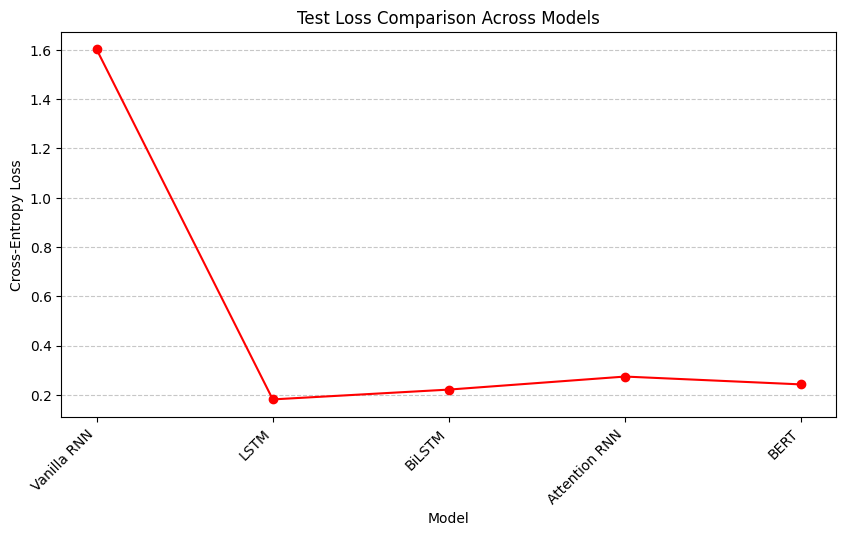

In [40]:
# Extract loss values
loss_values = df_test_results["Cross-Entropy Loss"].values

plt.figure(figsize=(10, 5))
plt.plot(models, loss_values, marker='o', linestyle='-', color='red')

plt.xlabel("Model")
plt.ylabel("Cross-Entropy Loss")
plt.title("Test Loss Comparison Across Models")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()

# **classification across categories**

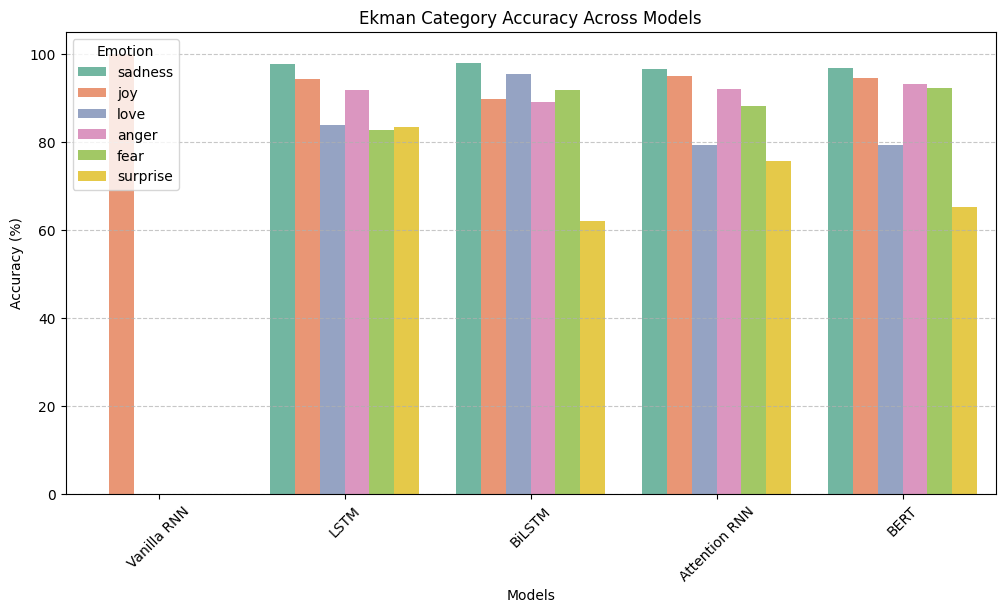

In [42]:
import seaborn as sns

df_long = df_per_emotion_accuracy.reset_index().melt(id_vars="index", var_name="Emotion", value_name="Accuracy")
df_long.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(12, 6))

sns.barplot(data=df_long, x="Model", y="Accuracy", hue="Emotion", palette='Set2')

plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Ekman Category Accuracy Across Models")
plt.xticks(rotation=45)
plt.legend(title="Emotion")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()



In [43]:
def map_emotions_to_category(predictions, labels, mapping, emotion_labels):

    category_predictions = {category: [] for category in mapping.keys()}
    category_labels = {category: [] for category in mapping.keys()}

    for sample_idx in range(predictions.shape[0]):
        pred_emotions = [emotion_labels[i] for i in range(len(emotion_labels)) if predictions[sample_idx, i] == 1]
        true_emotions = [emotion_labels[i] for i in range(len(emotion_labels)) if labels[sample_idx, i] == 1]

        for category, emotions in mapping.items():
            category_predictions[category].append(1 if any(e in emotions for e in pred_emotions) else 0)
            category_labels[category].append(1 if any(e in emotions for e in true_emotions) else 0)

    y_pred_binned = np.array([category_predictions[cat] for cat in mapping.keys()]).T
    y_true_binned = np.array([category_labels[cat] for cat in mapping.keys()]).T

    return y_pred_binned, y_true_binned

In [44]:
emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [45]:
sentiment_mapping = {
    "Positive": ["joy", "love"],
    "Negative": ["sadness", "anger", "fear"],
    "Neutral": ["surprise"]
}

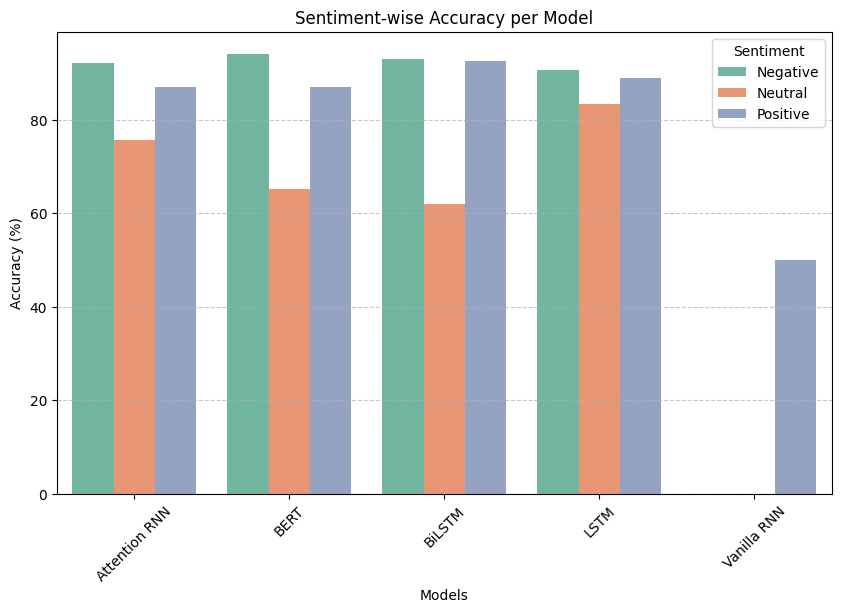

In [47]:
emotion_to_sentiment = {emotion: sentiment for sentiment, emotions in sentiment_mapping.items() for emotion in emotions}

df_long["Sentiment"] = df_long["Emotion"].map(emotion_to_sentiment)

df_sentiment = df_long.groupby(["Model", "Sentiment"])["Accuracy"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_sentiment, x="Model", y="Accuracy", hue="Sentiment", palette='Set2')

plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Sentiment-wise Accuracy per Model")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [48]:
df_long

,Model,Emotion,Accuracy,Sentiment
0,Vanilla RNN,sadness,0.000000,Negative
1,LSTM,sadness,97.727273,Negative
2,BiLSTM,sadness,97.902098,Negative
3,Attention RNN,sadness,96.503497,Negative
4,BERT,sadness,96.853147,Negative
5,Vanilla RNN,joy,100.000000,Positive
6,LSTM,joy,94.186047,Positive
7,BiLSTM,joy,89.825581,Positive
8,Attention RNN,joy,94.912791,Positive
9,BERT,joy,94.622093,Positive


# **between dataset analysis**

In [49]:
#load in reddit data

def red_text_to_sequence(text):
    return [twt_train_vocab.get(word, 0) for word in preprocess_text(text)]

column_names = ['text', 'label', 'rater']
red_test= pd.read_csv(DATA_DIR + 'RED_Test.tsv', sep='\t', header=None, names=column_names)
red_test = red_test[~red_test['label'].astype(str).str.contains('27')]
red_test["label"] = red_test["label"].apply(lambda x: [int(i) for i in str(x).split(",")])


In [51]:
with open(DATA_DIR_DICT + 'sentiment_dict.json', "r") as file:
    sentiment_mapping = json.load(file)

with open(DATA_DIR_DICT +"ekman_mapping_updated.json", "r") as file:
    ekman_mapping = json.load(file)

In [52]:
emotion_to_six = {}
for six_emotion, subcategories in ekman_mapping.items():
    for emotion in subcategories:
        emotion_to_six[emotion] = six_emotion


In [53]:
red_test.head(10)

,text,label,rater
0,I’m really sorry about your situation :( Altho...,[25],eecwqtt
1,It's wonderful because it's awful. At not with.,[0],ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",[13],een27c3
3,"I didn't know that, thank you for teaching me ...",[15],eelgwd1
5,Thank you for asking questions and recognizing...,[15],ef2nq7i
6,You’re welcome,[15],efdbh17
7,100%! Congrats on your job too!,[15],ef0ec3b
8,I’m sorry to hear that friend :(. It’s for the...,[24],ee8utmi
9,"Girlfriend weak as well, that jump was pathetic.",[25],eeni74k
10,[NAME] has towed the line of the Dark Side. He...,"[3, 10]",eeaf7fg


In [54]:
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity",
    "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness", "optimism", "pride", "realization", "relief",
    "remorse", "sadness", "surprise"
]


def map_labels_to_six(label_list, emotion_to_six):
    """
    Converts a multi-label emotion list into a single 6-emotion label.
    Uses the first mapped emotion found in the list.

    """
    string_labels = []
    for label in label_list:
        string_labels.append(emotion_labels[label])

    mapped_labels = [emotion_to_six[emotion] for emotion in string_labels if emotion in emotion_to_six]

    # Assign the first matching label, or default to "neutral" if none exist
    return mapped_labels[0] if mapped_labels else "neutral"

red_test["six_label"] = red_test["label"].apply(lambda labels: map_labels_to_six(labels, emotion_to_six))


In [55]:
red_test_vocab = build_vocab(red_test)

In [56]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
six_label_encoder = LabelEncoder()

# Fit the encoder to the 'six_label' column
six_label_encoder.fit(red_test['six_label'])
red_test['six_label_num'] = six_label_encoder.transform(red_test['six_label'])

In [57]:
label_names = {"sadness": 0, "joy": 1, "love": 2, "anger": 3, "fear": 4, "surprise": 5}

red_test["six_label_num_new"] = red_test["six_label"].map(label_names).astype(int)

In [58]:
red_test.head(10)

,text,label,rater,six_label,six_label_num,six_label_num_new
0,I’m really sorry about your situation :( Altho...,[25],eecwqtt,sadness,4,0
1,It's wonderful because it's awful. At not with.,[0],ed5f85d,love,3,2
2,"Kings fan here, good luck to you guys! Will be...",[13],een27c3,joy,2,1
3,"I didn't know that, thank you for teaching me ...",[15],eelgwd1,joy,2,1
5,Thank you for asking questions and recognizing...,[15],ef2nq7i,joy,2,1
6,You’re welcome,[15],efdbh17,joy,2,1
7,100%! Congrats on your job too!,[15],ef0ec3b,joy,2,1
8,I’m sorry to hear that friend :(. It’s for the...,[24],ee8utmi,sadness,4,0
9,"Girlfriend weak as well, that jump was pathetic.",[25],eeni74k,sadness,4,0
10,[NAME] has towed the line of the Dark Side. He...,"[3, 10]",eeaf7fg,anger,0,3


In [59]:
#Preprocessing

red_test_list = [word for sentence in red_test['text'] for word in preprocess_text(sentence)]
red_test_count = Counter(red_test_list)
red_test_vocab = {word: i + 1 for i, (word, _) in enumerate(red_test_count.most_common())}
red_text_to_sequence_test_vocab_size = len(twt_test_vocab) + 1

red_test['sequence'] = red_test['text'].apply(red_text_to_sequence)

red_test_max_len = max(len(seq) for seq in red_test['sequence'])
red_test['padded_sequence'] = red_test['sequence'].apply(lambda seq: seq + [0] * (red_test_max_len - len(seq)))
red_test_X = np.array(red_test['padded_sequence'].tolist())
red_test_y = np.array(red_test['six_label_num_new'])

In [60]:
red_test_dataset = EmotionDataset(red_test_X, red_test_y)
red_test_loader = DataLoader(red_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [61]:
#for bert

red_test_encodings = bert_tokenizer(list(red_test["text"]), truncation=True, padding=True, max_length=256)

# Convert labels to tensor
red_test_labels = torch.tensor(red_test["six_label_num_new"].values)

# Create PyTorch Dataset
class BertTwitterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

red_bert_test_dataset = BertTwitterDataset(red_test_encodings, red_test_labels)

# Create DataLoader
red_bert_test_loader = DataLoader(red_bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [62]:
def evaluate_models(models_dict, bert_model, test_loader_rnn, test_loader_bert, device="cuda"):
    results_dict = {}
    criterion = torch.nn.CrossEntropyLoss()

    # Evaluate RNN-based models
    for model_name, model in models_dict.items():
        if model_name == "BERT":
            continue

        model.to(device)
        model.eval()
        all_preds, all_labels = [], []
        total_loss = 0
        num_batches = 0

        with torch.no_grad():
            for batch in test_loader_rnn:
                inputs, labels = batch[0].to(device), batch[1].to(device)

                batch_size = inputs.size(0)
                hidden = model.init_hidden(batch_size)

                hidden = detach_hidden(hidden)

                outputs, hidden = model(inputs, hidden)

                loss = F.cross_entropy(outputs, labels)
                total_loss += loss.item()
                num_batches += 1

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                labels = labels.cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)

        accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds, average="weighted")
        avg_loss = total_loss / num_batches

        results_dict[model_name] = {"Accuracy (%)": accuracy, "F1-Score": f1, "Loss": avg_loss}

    # Evaluate BERT model
    bert_model.to(device)
    bert_model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in test_loader_bert:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = bert_model(**inputs)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item()
            num_batches += 1

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average="weighted")
    avg_loss = total_loss / num_batches

    results_dict["BERT"] = {"Accuracy (%)": accuracy, "F1-Score": f1, "Loss": avg_loss}
    df_results = pd.DataFrame(results_dict).T
    return df_results

In [63]:
df_twitter_to_reddit_results = evaluate_models(
    trained_models,
    bert_model,
    red_test_loader,
    red_bert_test_loader,
    device="cuda" if torch.cuda.is_available() else "cpu"
)


df_twitter_to_reddit_results

,Accuracy (%),F1-Score,Loss
Vanilla RNN,31.346154,0.150603,1.955237
LSTM,33.708791,0.276195,2.929613
BiLSTM,22.307692,0.227612,2.705374
Attention RNN,32.060440,0.270072,5.308286
BERT,41.510989,0.357952,3.659559


In [64]:
df_test_results

,Accuracy (%),F1-Score,Cross-Entropy Loss
Vanilla RNN,34.959350,0.181183,1.600880
LSTM,92.428862,0.924945,0.181545
BiLSTM,91.819106,0.918383,0.221365
Attention RNN,92.378049,0.923528,0.274201
BERT,92.632114,0.925658,0.242366


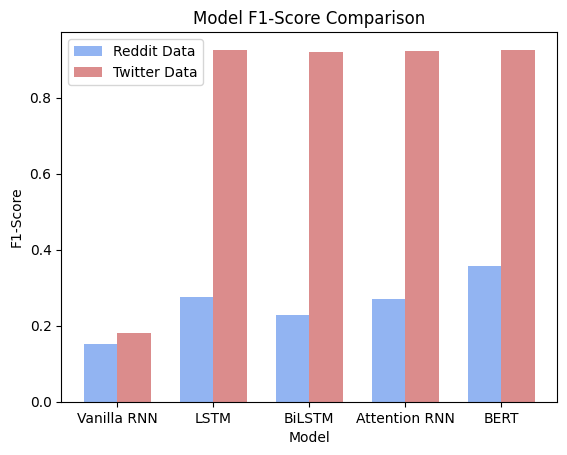

In [65]:
models = trained_models.keys()
pos = np.arange(len(df_test_results['F1-Score']))
width = 0.35

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(pos - width/2, df_twitter_to_reddit_results['F1-Score'], width, color="cornflowerblue", alpha=0.7, label = "Reddit Data")
bar2 = ax.bar(pos + width/2, df_test_results['F1-Score'], width, color="indianred", alpha=0.7, label = "Twitter Data")


# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(models)
ax.set_title("Model F1-Score Comparison")
ax.set_xlabel("Model")
ax.set_ylabel("F1-Score")
ax.legend()
plt.show()


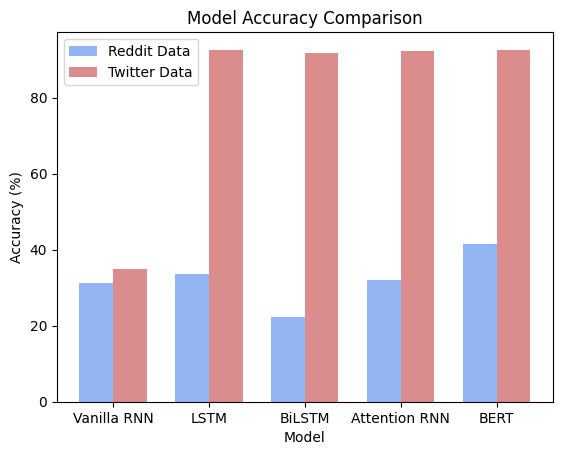

In [66]:
models = trained_models.keys()
pos = np.arange(len(df_test_results['Accuracy (%)']))
width = 0.35

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(pos - width/2, df_twitter_to_reddit_results['Accuracy (%)'], width, color="cornflowerblue", alpha=0.7, label = "Reddit Data")
bar2 = ax.bar(pos + width/2, df_test_results['Accuracy (%)'], width, color="indianred", alpha=0.7, label = "Twitter Data")


# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(models)
ax.set_title("Model Accuracy Comparison")
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy (%)")
ax.legend()
plt.show()

In [67]:
#statistical significance

from scipy.stats import ttest_rel

accuracy_twitter = df_test_results["Accuracy (%)"].values
accuracy_reddit = df_twitter_to_reddit_results["Accuracy (%)"].values

t_stat, p_value = ttest_rel(accuracy_twitter, accuracy_reddit)

print(f"Paired t-test Results: t-statistic = {t_stat:.5f}, p-value = {p_value:.5f}")

if p_value < 0.05:
    print("The accuracy difference between Twitter and Reddit is statistically significant.")
else:
    print("No significant difference in accuracy between Twitter and Reddit.")


Paired t-test Results: t-statistic = 4.18216, p-value = 0.01389
The accuracy difference between Twitter and Reddit is statistically significant.


In [68]:
# plot correct classifications per model for reddit data

class_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# dictionary to store per-emotion accuracy
per_emotion_accuracy = {}

for name, model in trained_models.items():
    all_preds, all_labels = [], []

    with torch.no_grad():
        if name == "BERT":  # Special handling for BERT
            for batch in red_bert_test_loader:
                inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                outputs = model(input_ids=inputs, attention_mask=(inputs > 0).long())
                preds = outputs.logits.argmax(dim=1).cpu().numpy()
                labels = labels.cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)
        else:  # Handling for other models
            for batch in red_test_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)

                batch_size = inputs.size(0)
                hidden = model.init_hidden(batch_size)

                hidden = detach_hidden(hidden)

                preds = torch.argmax(model(inputs, hidden)[0], dim=1).cpu().numpy()
                labels = labels.cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    emotion_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1) * 100
    per_emotion_accuracy[name] = dict(zip(class_names, emotion_accuracy))

dftr_per_emotion_accuracy = pd.DataFrame(per_emotion_accuracy).T

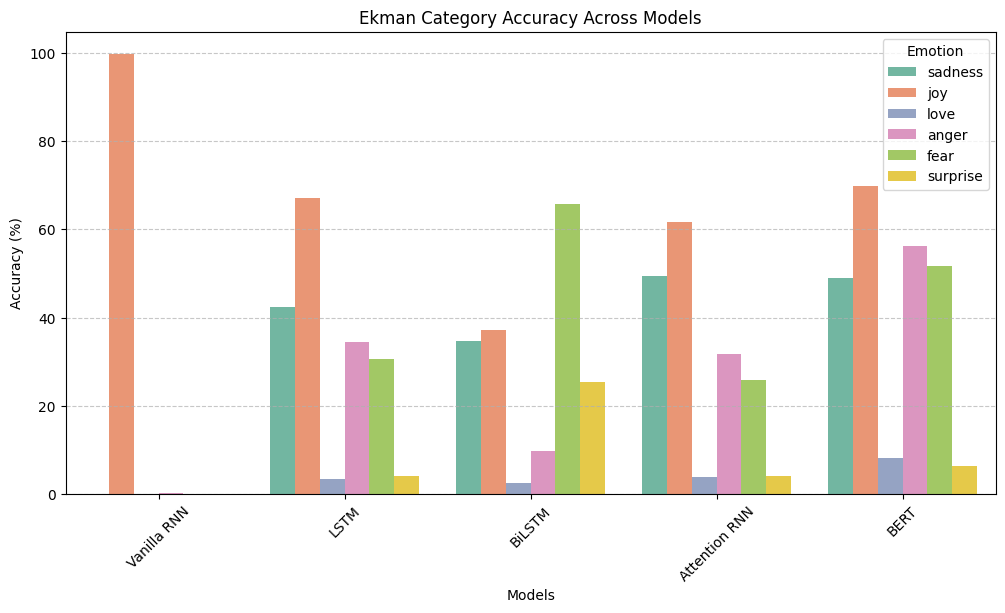

In [69]:
import seaborn as sns

df_long = dftr_per_emotion_accuracy.reset_index().melt(id_vars="index", var_name="Emotion", value_name="Accuracy")
df_long.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(12, 6))

sns.barplot(data=df_long, x="Model", y="Accuracy", hue="Emotion", palette='Set2')

plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Ekman Category Accuracy Across Models")
plt.xticks(rotation=45)
plt.legend(title="Emotion")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

